In [1]:
import pandas as pd
import numpy as np
import os
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 0

In [2]:
import re, scipy, os, statistics, string
import pandas as pd
import numpy as np
from collections import Counter
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from textblob import TextBlob
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction import DictVectorizer, FeatureHasher


# below are only applied to n-grams

stop_words = set(stopwords.words('english')) 
stemmer = PorterStemmer()
vectorizer = DictVectorizer(sparse = True)
# vectorizer = FeatureHasher(n_features=2**20)

stop_words = stop_words.union({'http','https','www','href','src','img'})
stop_words = stop_words.union({'ll','re','ve'}) # contractions more than 1 letter

# t_contractions = pd.DataFrame(pd.read_html('https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions')[1]).Contraction
# t_contractions = {a.replace('’',"'").replace("'","").lower() for a in t_contractions if a.endswith("t")}
# # t_contractions
# t_contractions = {'aint'}.union(t_contractions)

t_contractions = {'cant', 'wonnot', 'shouldnt', 'arent', 'daresnt', 'shallnt', 'wont', 'shant', 'darent', 'maynt', 'wat', \
    'oughtnt', 'couldnt', 'hadnt', 'didnt', 'yallrent', 'yaint', 'wasnt', 'dont', 'isnt', 'werent', 'doesnt', 'aint', 'havent', \
        'wouldnt', 'hasnt', 'neednt', 'mustnt', 'amnt', 'dasnt', 'mightnt', 'idnt', 'willnt'}

negations = {'no','not','cannot'}.union(t_contractions)



In [6]:
emotion_map = {'sadness':0, 'joy':1, 'love':2, 'anger':3,'fear':4,'surprise':5, 0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
emotions = ['sadness', 'joy', 'love', 'anger','fear','surprise']

docs_df = load('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/merged_training.pkl').reset_index(drop=True)
docs_df.columns = ['text','query']
docs_df

,text,query
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love
...,...,...
416804,that was what i felt when i was finally accept...,joy
416805,i take every day as it comes i m just focussin...,fear
416806,i just suddenly feel that everything was fake,sadness
416807,im feeling more eager than ever to claw back w...,joy


In [7]:
if not os.path.exists('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/tok.pkl'):
    docs_df['tok'] = [word_tokenize(a) for a in docs_df.text]
    docs_df['tok'].to_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/tok.pkl')
else:
    docs_df['tok'] = pd.read_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/tok.pkl')
# docs_df

In [8]:
# only used for counting emotions
if not os.path.exists('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/stem.pkl'):
    docs_df['stem'] = [[stemmer.stem(b) for b in a] for a in docs_df.tok]
    docs_df['stem'].to_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/stem.pkl')
else:
    docs_df['stem'] = pd.read_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/stem.pkl')
# docs_df

# may require downloading nltk packages
emotion_synonyms, emotion_antonyms = dict(), dict()
for i in pd.unique(docs_df['query']):
    emotion_synonyms[i], emotion_antonyms[i] = set(), set()
    for syn in wordnet.synsets(i):
        for l in syn.lemmas():
            if '_' not in l.name():
                emotion_synonyms[i].add(l.name())
            if l.antonyms() and '_' not in l.antonyms()[0].name():
                emotion_antonyms[i].add(l.antonyms()[0].name())
emotion_terms_all = {stemmer.stem(i) for a in emotion_synonyms for i in emotion_synonyms[a] }.union({stemmer.stem(i) for a in emotion_antonyms for i in emotion_antonyms[a] })
# emotion_terms_all

In [9]:
if not os.path.exists('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/pos_tup.pkl'):
    docs_df['pos_tup'] = [nltk.tag.pos_tag(a) for a in docs_df.tok]
    docs_df['pos_tup'].to_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/pos_tup.pkl')
else:
    docs_df['pos_tup'] = pd.read_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/pos_tup.pkl')
    
docs_df['pos'] = [[b[1] for b in a] for a in docs_df.pos_tup]
# docs_df

In [10]:
def sentiment_textblob(row):
    classifier = TextBlob(row)
    polarity = classifier.sentiment.polarity
    subjectivity = classifier.sentiment.subjectivity
    return polarity,subjectivity

if not os.path.exists('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/polarity_subjectivity.pkl'):
    docs_df[['polarity', 'subjectivity']] = pd.DataFrame([sentiment_textblob(a) for a in docs_df.text], columns=['polarity', 'subjectivity'])
    docs_df[['polarity', 'subjectivity']].to_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/polarity_subjectivity.pkl')
else:
    docs_df[['polarity', 'subjectivity']] = pd.read_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/polarity_subjectivity.pkl')

### Info on POS tags
https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk

- noun: contains NN
- pronoun: countians PR
- verb: contains VB
- adverb: contains RB
- modal auxiliary: MD
- adjective: contains JJ
- causal conjunction: IN

In [11]:
# docno
pos_pref = ['NN', 'PR', 'VB', 'RB', 'MD', 'JJ', 'IN']
pos_list = list(docs_df.pos.explode().unique())
# pos_list

for pref in pos_pref:
    tags = {a for a in pos_list if pref in a}
    docs_df[pref] = [sum(1 for tag in row if tag in tags) for row in docs_df.pos]
    
docs_df['pos_sum'] = docs_df[pos_pref].sum(axis=1)
docs_df[pos_pref] = docs_df[pos_pref].div(docs_df['pos_sum'], axis=0)

# calculate ratio of emotion terms among stem
docs_df['er'] = [sum(1 for tag in row if tag in emotion_terms_all) for row in docs_df.stem] / docs_df['pos_sum']

# calculate ratio of negatives
docs_df['neg'] = [sum(1 for tag in row if tag in negations) for row in docs_df.tok] / docs_df['pos_sum']



numeric_columns = ["polarity", "subjectivity", "er", "neg"] + pos_pref
print(numeric_columns)

['polarity', 'subjectivity', 'er', 'neg', 'NN', 'PR', 'VB', 'RB', 'MD', 'JJ', 'IN']


In [12]:

def create_ngrams(text, nrange=(1, 1)):
    text_features = [] 
    text = [stemmer.stem(w) for w in text.split() if w not in stop_words and len(w) > 1]
    text = [a[:-1] if a in t_contractions else a for a in text]
    
    for n in range(nrange[0], nrange[1]+1): 
        text_features += nltk.ngrams(text, n)
    return dict(Counter(text_features))   # Tf



In [13]:
docs_df[numeric_columns]

,polarity,subjectivity,er,neg,NN,PR,VB,RB,MD,JJ,IN
0,-1.000000,1.000000,0.0,0.000000,0.181818,0.227273,0.227273,0.136364,0.0,0.090909,0.136364
1,-1.000000,1.000000,0.0,0.000000,0.200000,0.000000,0.200000,0.200000,0.0,0.400000,0.000000
2,0.284091,0.438636,0.0,0.000000,0.260870,0.043478,0.217391,0.130435,0.0,0.130435,0.217391
3,-0.096875,0.225000,0.0,0.000000,0.250000,0.000000,0.250000,0.125000,0.0,0.375000,0.000000
4,0.243750,0.568750,0.0,0.000000,0.266667,0.000000,0.266667,0.133333,0.0,0.266667,0.066667
...,...,...,...,...,...,...,...,...,...,...,...
416804,0.000000,1.000000,0.0,0.000000,0.333333,0.000000,0.333333,0.111111,0.0,0.055556,0.166667
416805,0.000000,0.750000,0.0,0.027778,0.250000,0.083333,0.277778,0.111111,0.0,0.138889,0.138889
416806,-0.250000,0.750000,0.0,0.000000,0.250000,0.000000,0.250000,0.250000,0.0,0.125000,0.125000
416807,0.125000,0.141667,0.0,0.000000,0.312500,0.000000,0.312500,0.125000,0.0,0.125000,0.125000


In [14]:
def create_features_docs_df(df, nrange=(1, 1)):
    cols_ = [tuple([a.upper()]) for a in numeric_columns]
    
    ng = [create_ngrams(i, nrange=nrange) for i in df.text]
    
    # print(ng[:5])
    
    res = list(df[numeric_columns].rename(columns={o: n for o,n in zip(numeric_columns,cols_)}).to_dict(orient='index').items())
    
    # print(df.text[45645])
    
    # print(res[:5])

    
    ret = [{**a[1], **b} for a,b in zip(res, ng)]

    # print(ret[:5])
    return ret
    # return res[45645][1]['tok']


# create_features_docs_df(docs_df, nrange=(1,4))



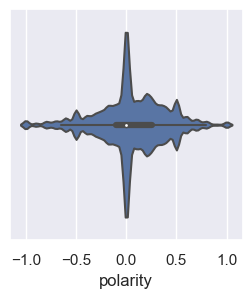

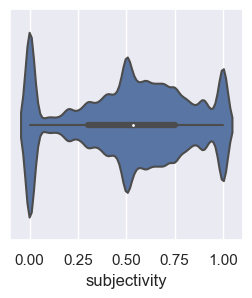

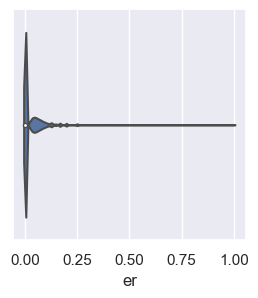

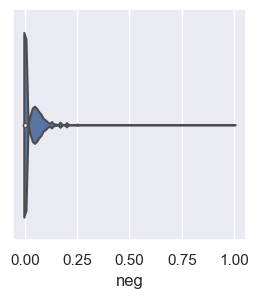

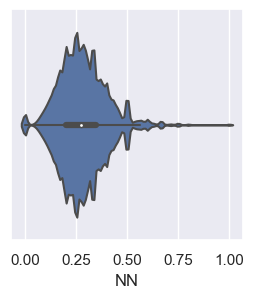

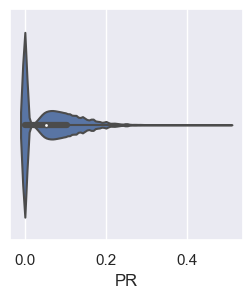

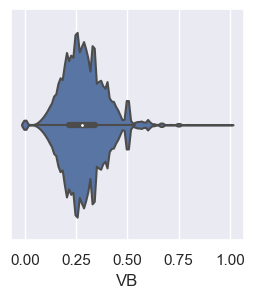

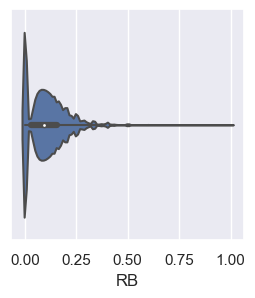

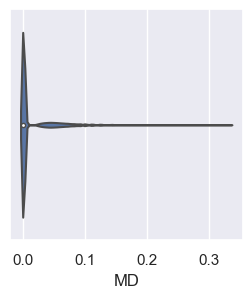

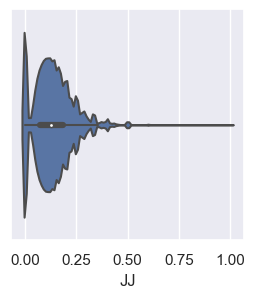

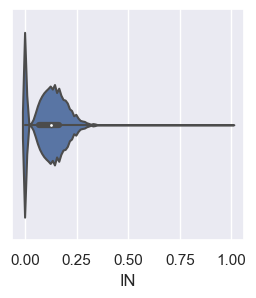

In [33]:
sns.set(rc={"figure.figsize":(3,3)})
for i in numeric_columns:
    sns.violinplot(docs_df, x=i)
    plt.show()

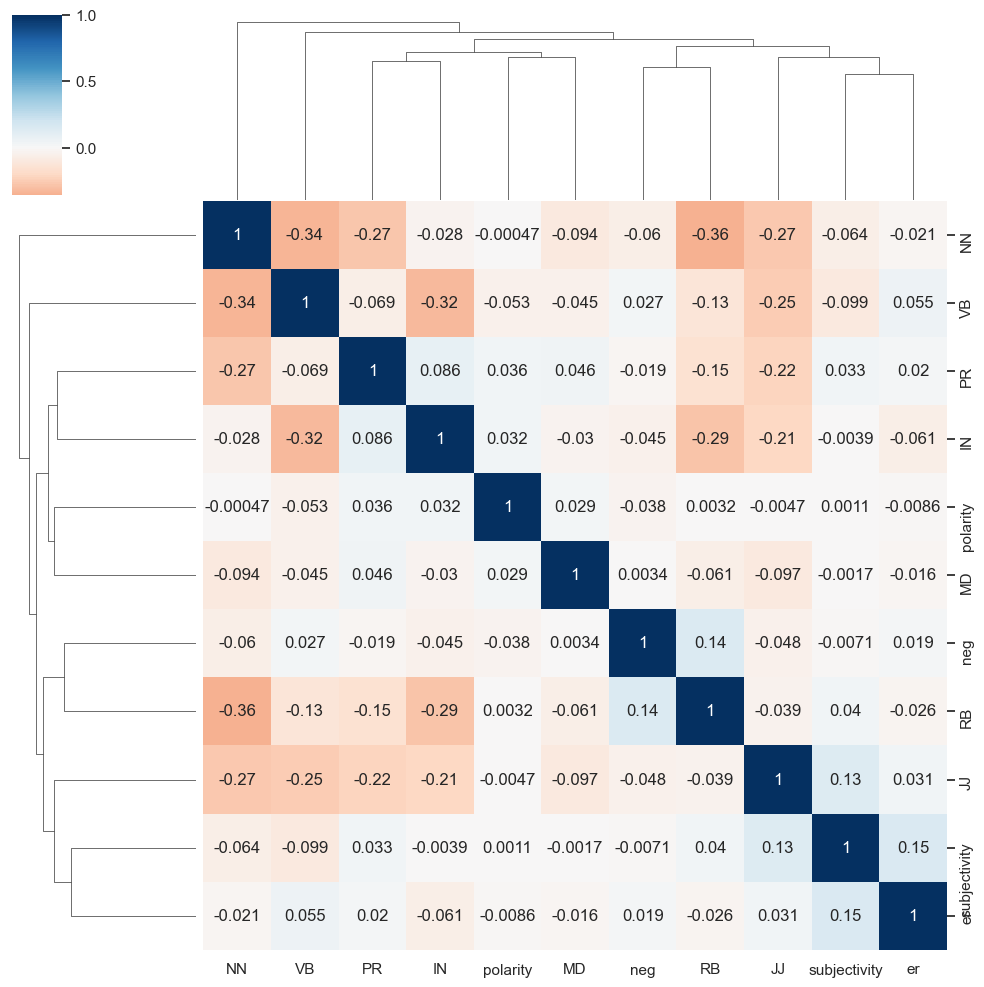

In [41]:
sns.clustermap(docs_df[numeric_columns].corr(),cmap='RdBu', annot=True, center=0)

In [38]:
import pickle
if not os.path.exists('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/X_all.pkl'):
    X_all = create_features_docs_df(docs_df, nrange=(1,4))
    with open("emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/X_all.pkl",'wb') as file:
        pickle.dump(X_all, file)
else:
    with open('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/X_all.pkl', 'rb')  as file:
        X_all = pickle.load(file)
        file.close()
    
y_all = docs_df['query']
X_all[:2]

[{('POLARITY',): -1.0,
  ('SUBJECTIVITY',): 1.0,
  ('ER',): 0.0,
  ('NEG',): 0.0,
  ('NN',): 0.18181818181818182,
  ('PR',): 0.22727272727272727,
  ('VB',): 0.22727272727272727,
  ('RB',): 0.13636363636363635,
  ('MD',): 0.0,
  ('JJ',): 0.09090909090909091,
  ('IN',): 0.13636363636363635,
  ('feel',): 1,
  ('aw',): 1,
  ('job',): 1,
  ('get',): 1,
  ('posit',): 1,
  ('succeed',): 1,
  ('happen',): 1,
  ('feel', 'aw'): 1,
  ('aw', 'job'): 1,
  ('job', 'get'): 1,
  ('get', 'posit'): 1,
  ('posit', 'succeed'): 1,
  ('succeed', 'happen'): 1,
  ('feel', 'aw', 'job'): 1,
  ('aw', 'job', 'get'): 1,
  ('job', 'get', 'posit'): 1,
  ('get', 'posit', 'succeed'): 1,
  ('posit', 'succeed', 'happen'): 1,
  ('feel', 'aw', 'job', 'get'): 1,
  ('aw', 'job', 'get', 'posit'): 1,
  ('job', 'get', 'posit', 'succeed'): 1,
  ('get', 'posit', 'succeed', 'happen'): 1},
 {('POLARITY',): -1.0,
  ('SUBJECTIVITY',): 1.0,
  ('ER',): 0.0,
  ('NEG',): 0.0,
  ('NN',): 0.2,
  ('PR',): 0.0,
  ('VB',): 0.2,
  ('RB',): 0.

In [18]:
from sklearn.model_selection import train_test_split

# X_train_, X_test_, y_train, y_test = train_test_split(X_all, y_all, train_size=0.05, random_state = RANDOM_STATE)
X_train_, X_test_, y_train, y_test = train_test_split(X_all, y_all, train_size=0.25, random_state = RANDOM_STATE)

In [19]:
X_train = vectorizer.fit_transform(X_train_)
X_test = vectorizer.transform(X_test_)

X_train

<104202x1747653 sparse matrix of type '<class 'numpy.float64'>'
	with 4364071 stored elements in Compressed Sparse Row format>

In [20]:
if not os.path.exists('project_classify_models/vectorizer_0.25.joblib'):
    dump(vectorizer, "project_classify_models/vectorizer_0.25.joblib")

In [21]:
print(X_train.shape)
print(X_test.shape)

(104202, 1747653)
(312607, 1747653)


In [22]:
# from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, \
PrecisionRecallDisplay
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier

from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import OrdinalEncoder, label_binarize
from sklearn.base import clone

In [23]:
RANDOM_STATE = 0

def train_test(tuned_param, fitted_clf, X_train, X_test, y_train, y_test):
    report = pd.DataFrame()
    
    report['model'] = [fitted_clf.__class__.__name__]
    report[tuned_param] = [fitted_clf.get_params()[tuned_param]]
    
    
    metrics_names = ['accuracy','balanced_accuracy','precision','weighted_precision','recall','weighted_recall','f1','weighted_f1']
    metrics = [
        accuracy_score,
        balanced_accuracy_score,

        lambda x, y: precision_score(x, y, average='macro'),
        lambda x, y: precision_score(x, y, average='weighted'),
        
        lambda x, y: recall_score(x, y, average='macro'),
        lambda x, y: recall_score(x, y, average='weighted'),
        
        lambda x, y: f1_score(x, y, average='macro'),
        lambda x, y: f1_score(x, y, average='weighted')
    ]
    
    for i in range(len(metrics)):
        report[metrics_names[i]+'_train'] = [metrics[i](y_train, fitted_clf.predict(X_train))]
        report[metrics_names[i]+'_test'] = [metrics[i](y_test, fitted_clf.predict(X_test))]
    
    return report

In [24]:
def train_test_by_class(tuned_param, fitted_clf, X_train, X_test, y_train, y_test):
    train_report = pd.DataFrame(classification_report(y_train, fitted_clf.predict(X_train), output_dict=True)).transpose()
    test_report = pd.DataFrame(classification_report(y_test, fitted_clf.predict(X_test), output_dict=True)).transpose()
    train_report.columns = [a+'_train' for a in train_report.columns]
    test_report.columns = [a+'_test' for a in test_report.columns]
    
    report = pd.DataFrame()
    for i in ['precision','recall','f1-score']:
        report = pd.concat([report, train_report[i+'_train'], test_report[i+'_test']], axis=1)
    report = report.reset_index().rename(columns={'index':'class'})
    numeric_columns = list(report.columns)
    report['model'] = fitted_clf.__class__.__name__
    report[tuned_param] = fitted_clf.get_params()[tuned_param]

    return report[['model',tuned_param]+numeric_columns]


In [25]:

# svc = SVC()
lsvc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)

# rforest = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=6)
# rforest_best = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=6, max_samples=0.5)

# dtree = DecisionTreeClassifier(random_state=RANDOM_STATE)
# lr = LogisticRegression()

In [ ]:
# ctest = sorted([round(a, 4) for a in set(np.linspace(0.005,0.16,32)).union(set(np.linspace(0.02,0.50,25)))])
# ctest

In [37]:
# np.geomspace(0.001, 10, 9)

In [36]:
# sorted(set(np.geomspace(0.001, 10, 9)) - set(ctest))

In [35]:
# np.geomspace(0.001, 1000, 17)

In [30]:


res, res_class = pd.DataFrame(), pd.DataFrame()
savetime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')


# clifs = [lsvc, rforest, dtree]
# clifs = [lsvc, rforest, rforest_best]
# clifs = [rforest_best]
# clifs = [rforest, rforest_best, lr]

# clifs = [LinearSVC(random_state=RANDOM_STATE, max_iter=10000, C=a) for a in np.logspace(-2,0,10) ]
# clifs = [LinearSVC(random_state=RANDOM_STATE, max_iter=10000, C=a) for a in np.linspace(0.13,0.36,20)]
# clifs = [LinearSVC(random_state=RANDOM_STATE, max_iter=10000, C=a) for a in np.linspace(0.02,0.50,25)]
# clifs = [LinearSVC(random_state=RANDOM_STATE, max_iter=10000, C=a) for a in ctest]

# clifs = [LinearSVC(random_state=RANDOM_STATE, max_iter=10000, C=a) for a in sorted(set(np.geomspace(0.001, 1000, 20)) - set(ctest))]
# clifs = [LinearSVC(random_state=RANDOM_STATE, max_iter=10000, C=a) for a in sorted(set(np.geomspace(0.001, 10, 9)) - set(ctest))]

# best 
clifs = [LinearSVC(random_state=RANDOM_STATE, max_iter=10000, C=0.085)]

tuned_param = 'C'

# clifs = [DummyClassifier(strategy = a, random_state=RANDOM_STATE) for a in ['uniform','most_frequent']]
# tuned_param = 'strategy'


for clf in clifs:
    # clf_name = clf.__class__.__name__
    print(clf.get_params()[tuned_param])
    %time clf.fit(X_train, y_train)
    
    # print(clf_name)
    report = train_test(tuned_param, clf, X_train, X_test, y_train, y_test)
    res = pd.concat([res, report])
    # print(report)
    report_class = train_test_by_class(tuned_param, clf, X_train, X_test, y_train, y_test)
    res_class = pd.concat([res_class, report_class])
    # print(report_class)
    
# organize results for each class
temp = res_class.sort_values(['class',tuned_param,'model']).reset_index(drop=True)
temp = temp.loc[temp['class'] != 'accuracy',:]
metric_cols = [a for a in temp.columns if '_train' in a or '_test' in a]
info_cols = [a for a in temp.columns if a not in metric_cols and a != 'class']
classes = emotions + ['macro avg','weighted avg']
res_class2 = pd.DataFrame()

for c in classes:
    if res_class2.empty:
        temp2 = temp.loc[temp['class'] == c, :].drop(columns=['class'])
        temp2.columns = info_cols + [c+'_'+a for a in metric_cols]
    else:
        temp2 = temp.loc[temp['class'] == c, metric_cols]
        temp2.columns = [c+'_'+a for a in metric_cols]
    res_class2 = pd.concat([res_class2, temp2.reset_index(drop=True)], axis=1)
res_class2

    
# res
if 'C' in clifs[0].get_params() and clifs[0].get_params()['C'] == 0.085:
    dump(clifs[0], "project_classify_models/project_classify_LinearSVC.joblib")
    res.sort_values(tuned_param,ascending=False).to_csv("project_classify_results/chosen_model_test_results_"+ savetime + '.csv', index=False)
    res_class2.to_csv("project_classify_results/chosen_model_test_results_class_"+ savetime + '.csv', index=False)
else:
    print(savetime)
    res.sort_values(tuned_param,ascending=False).to_csv("project_classify_results/test_results_"+ savetime + '.csv', index=False)
    res_class2.to_csv("project_classify_results/test_results_class_"+ savetime + '.csv', index=False)

0.085
CPU times: total: 18.6 s
Wall time: 18.6 s
